In [1]:
import os
# running from Root directory
os.chdir("..")

In [2]:
from connectome import Connectome
from connectome_network import ConnectomeNetwork
from connectome_types import SynapseSide, cell_types, ClfType, m_types, CONNECTOME_NEURON_TABLE_PATH
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
from collections import Counter
clf_type_space = [e.value for e in ClfType]

In [3]:
neurons_df = pd.read_csv(CONNECTOME_NEURON_TABLE_PATH)
print(len(neurons_df))
neurons_df.head()

71736


,Unnamed: 0,root_id,volume,clf_type,cell_type,mtype,ds_num_of_pre_synapses,ds_num_of_post_synapses,ds_pre_syn_mean_weight,ds_post_syn_mean_weight,...,num_of_pre_synapses,num_of_post_synapses,num_of_ex_pre_synapses,num_of_inh_pre_synapses,pre_syn_mean_weight,pre_syn_sum_weight,ex_pre_syn_mean_weight,ex_pre_syn_sum_weight,inh_pre_syn_mean_weight,inh_pre_syn_sum_weight
0,0,864691134784325628,234.475029,E,6P-IT,L6tall-c,50,3,4245.760000,3470.666667,...,1,0,1,0,1096.000000,1096.0,1096.000000,1096.0,NaN,0.0
1,1,864691134807855033,313.159680,E,6P-IT,L6tall-c,68,4,4804.588235,1398.000000,...,0,1,0,0,NaN,0.0,NaN,0.0,NaN,0.0
2,2,864691134884743162,318.771200,E,6P-IT,L6short-a,1661,9,6338.362432,2671.111111,...,50,5,27,23,5991.680000,299584.0,6356.888889,171636.0,5562.956522,127948.0
3,3,864691134884747514,207.237120,E,6P-IT,L6short-b,659,28,7949.116844,4742.714286,...,25,17,20,5,4935.680000,123392.0,5514.800000,110296.0,2619.200000,13096.0
4,4,864691134884754426,205.180109,E,6P-CT,L6tall-a,1779,557,6489.351321,6157.572711,...,95,330,61,34,5751.284211,546372.0,5548.327869,338448.0,6115.411765,207924.0


In [4]:
# neurons_df[neurons_df.cell_type == 'MC'].mtype.value_counts()
# neurons_df[neurons_df.cell_type == 'BC'].mtype.value_counts()

In [4]:
neurons_df_sorted = neurons_df.sort_values('cell_type')

In [5]:
ex_color =  "#FF0000" # red, dark red: "#A2142F"
inh_color =  "#0072BD"   

# cell types colors
cell_types = sorted(neurons_df['cell_type'].unique())

blue_cmap = plt.cm.Blues(np.linspace(0.5, 1, 7))
red_cmap = plt.cm.Reds(np.linspace(0.6, 0.9, 4))
custom_palette = {cell_type: color for cell_type, color in zip(cell_types[:7], blue_cmap)}
custom_palette.update({cell_type: color for cell_type, color in zip(cell_types[7:], red_cmap)})

combine_cell_type_order = cell_types.copy()
combine_cell_type_order += ['E', 'I', 'All']

# combine_cell_type_order = ['23P',
#  '4P',
#  '5P-ET',
#  '5P-IT',
#  '5P-NP',
#  '6P-CT',
#  '6P-IT',
#   'All E',
#  'BC',
#  'BPC',
#  'MC',
#  'NGC',
#  'All I',
#  'All']

### Neuron type distribution

Ex neurons: 63904
Inh neurons: 7832
E/I ratio: 89.08 %


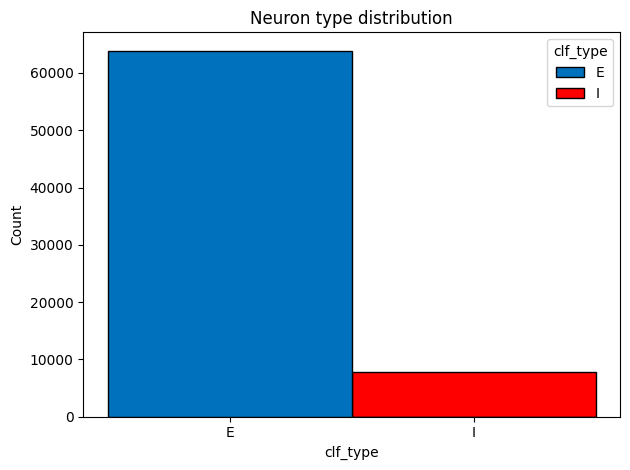

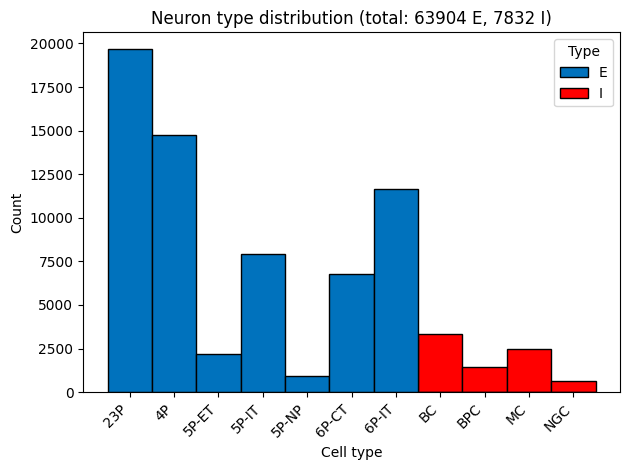

In [7]:
ex_neurons = len(neurons_df[neurons_df.clf_type == 'E'])
inh_neurons = len(neurons_df[neurons_df.clf_type == 'I'])

print(f'Ex neurons: {ex_neurons}')
print(f'Inh neurons: {inh_neurons}')
print(f'E/I ratio: {100*ex_neurons/(inh_neurons+ex_neurons):.2f} %')

fig, ax = plt.subplots()
sns.histplot(data=neurons_df, x="clf_type", hue="clf_type", 
             palette={"I": inh_color, "E": ex_color}, alpha=1, ax=ax)
ax.set_title("Neuron type distribution");
plt.tight_layout();plt.show()

fig, ax = plt.subplots()
sns.histplot(data=neurons_df_sorted, x="cell_type", hue="clf_type", 
             palette={"I": inh_color, "E": ex_color}, alpha=1, ax=ax)
ax.set_title("Neuron type distribution (total: 63904 E, 7832 I)");plt.xticks(rotation=45, ha='right');
ax.set_xlabel("Cell type")
sns.move_legend(ax, title='Type', loc='best')
plt.tight_layout();plt.show()
# fig.savefig('figures/neuron_type_dist.png')

### Combine df

In [8]:
data_cols = ['ds_num_of_pre_synapses', 'ds_num_of_post_synapses',
             'ds_pre_syn_mean_weight', 'ds_post_syn_mean_weight',
             'ds_pre_syn_sum_weight', 'ds_post_syn_sum_weight'
            ]
all_type_df = neurons_df[data_cols].copy()
all_type_df['type_'] = ['All'] * len(all_type_df)
all_type_df['clf_type'] = ['All'] * len(all_type_df)

cell_type_df = neurons_df[['cell_type', 'clf_type'] + data_cols].copy()
cell_type_df = cell_type_df.rename(columns={'cell_type': 'type_'})

clf_type_df = neurons_df[['clf_type'] + data_cols].copy()
clf_type_df['type_'] = clf_type_df['clf_type'].copy()
clf_type_df.head()

combined_df = pd.concat([cell_type_df, clf_type_df, all_type_df], ignore_index=True)
combined_df['type_'] = pd.Categorical(combined_df['type_'], categories=combine_cell_type_order, ordered=True)

# 3 tables concat
print(len(combined_df)/3)
combined_df.head()

71736.0


,type_,clf_type,ds_num_of_pre_synapses,ds_num_of_post_synapses,ds_pre_syn_mean_weight,ds_post_syn_mean_weight,ds_pre_syn_sum_weight,ds_post_syn_sum_weight
0,6P-IT,E,50,3,4245.760000,3470.666667,212288,10412.0
1,6P-IT,E,68,4,4804.588235,1398.000000,326712,5592.0
2,6P-IT,E,1661,9,6338.362432,2671.111111,10528020,24040.0
3,6P-IT,E,659,28,7949.116844,4742.714286,5238468,132796.0
4,6P-CT,E,1779,557,6489.351321,6157.572711,11544556,3429768.0


In [9]:
comb_cell_type_counts = combined_df['type_'].value_counts()
comb_cell_type_counts_labels = [f"{ct} (N={comb_cell_type_counts[ct]})" for ct in combine_cell_type_order]
comb_cell_type_counts_labels

['23P (N=19654)',
 '4P (N=14736)',
 '5P-ET (N=2191)',
 '5P-IT (N=7923)',
 '5P-NP (N=941)',
 '6P-CT (N=6791)',
 '6P-IT (N=11668)',
 'BC (N=3328)',
 'BPC (N=1433)',
 'MC (N=2450)',
 'NGC (N=621)',
 'E (N=63904)',
 'I (N=7832)',
 'All (N=71736)']

### Degree distribution (Number of synapses)
whole dataset: 300M synapses 

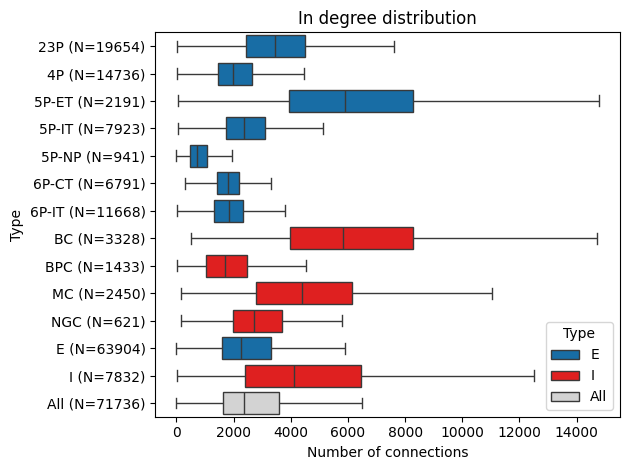

In [10]:
fig, ax = plt.subplots()
sns.boxplot(y="type_", x="ds_num_of_pre_synapses", hue="clf_type", data=combined_df,
            palette={"I": inh_color, "E": ex_color, "All": "lightgray"}, showfliers=False)
plt.title("In degree distribution")
plt.xlabel("Number of connections")
plt.ylabel("Type")
ax.set_yticks(range(len(comb_cell_type_counts_labels)))
ax.set_yticklabels(comb_cell_type_counts_labels)
plt.legend(title="Type");plt.tight_layout();plt.show()
# fig.savefig('figures/in_degree_dist.png')

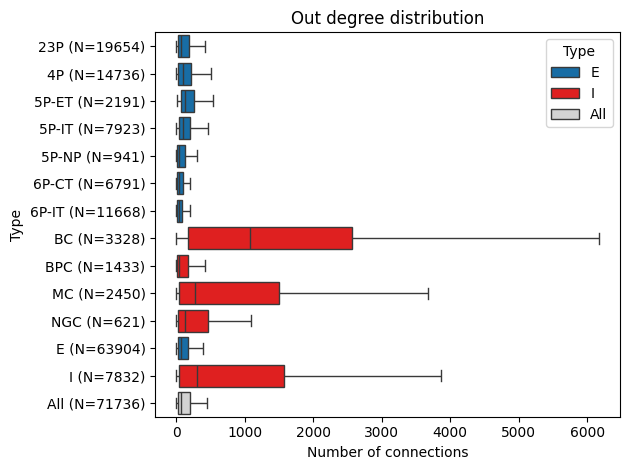

In [11]:
fig, ax = plt.subplots()
sns.boxplot(y="type_", x="ds_num_of_post_synapses", hue="clf_type", data=combined_df,
            palette={"I": inh_color, "E": ex_color, "All": "lightgray"}, showfliers=False)
plt.title("Out degree distribution")
plt.xlabel("Number of connections")
plt.ylabel("Type")
ax.set_yticks(range(len(comb_cell_type_counts_labels)))
ax.set_yticklabels(comb_cell_type_counts_labels)
plt.legend(title="Type");plt.tight_layout();plt.show()
# fig.savefig('figures/out_degree_dist.png')

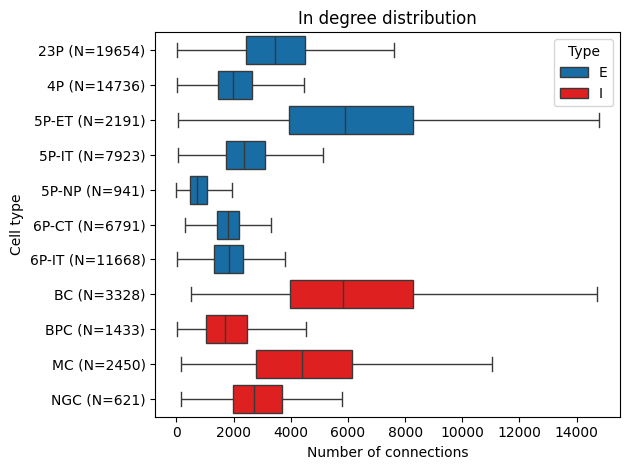

In [12]:
cell_type_counts = neurons_df_sorted['cell_type'].value_counts()
cell_type_counts_labels = [f"{ct} (N={cell_type_counts[ct]})" for ct in neurons_df_sorted['cell_type'].unique()]

fig, ax = plt.subplots()
sns.boxplot(y="cell_type", x="ds_num_of_pre_synapses", hue="clf_type", data=neurons_df_sorted,
            palette={"I": inh_color, "E": ex_color}, showfliers=False)
plt.title("In degree distribution")
plt.xlabel("Number of connections"); plt.ylabel("Cell type"); 

ax.set_yticks(range(len(cell_type_counts_labels)))
ax.set_yticklabels(cell_type_counts_labels)

sns.move_legend(ax, title='Type', loc='best')
plt.tight_layout();plt.show(); 
# fig.savefig('figures/in_degree_dist.png')

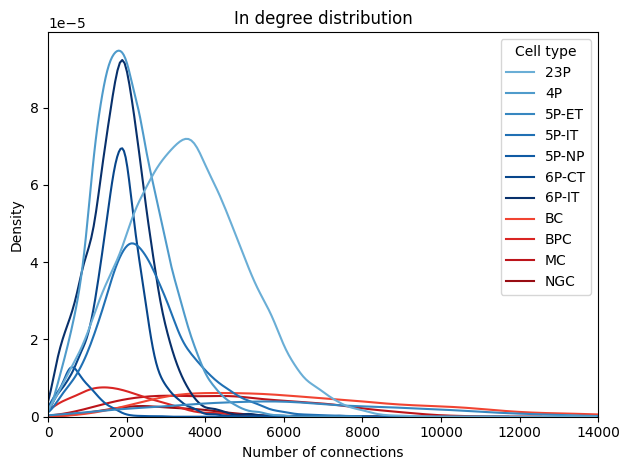

In [13]:
# supplementary materials 
fig, ax = plt.subplots()
sns.kdeplot(data=neurons_df_sorted, x="ds_num_of_pre_synapses", hue="cell_type", ax=ax,
            palette=custom_palette, alpha=1)
ax.set_xlim(0, 14000)
ax.set_title("In degree distribution");
ax.set_xlabel("Number of connections"); sns.move_legend(ax, title='Cell type', loc='best')
plt.tight_layout();plt.show()

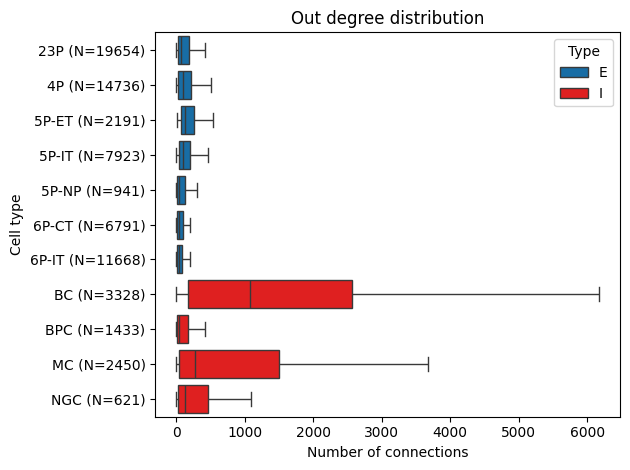

In [14]:
fig, ax = plt.subplots()
sns.boxplot(y="cell_type", x="ds_num_of_post_synapses", hue="clf_type", data=neurons_df_sorted,
            palette={"I": inh_color, "E": ex_color}, showfliers=False)
plt.title("Out degree distribution")
plt.xlabel("Number of connections"); plt.ylabel("Cell type"); 
sns.move_legend(ax, title='Type', loc='best')
ax.set_yticks(range(len(cell_type_counts_labels)))
ax.set_yticklabels(cell_type_counts_labels)
plt.tight_layout();plt.show()
# fig.savefig('figures/out_degree_dist.png')

### Means of weights

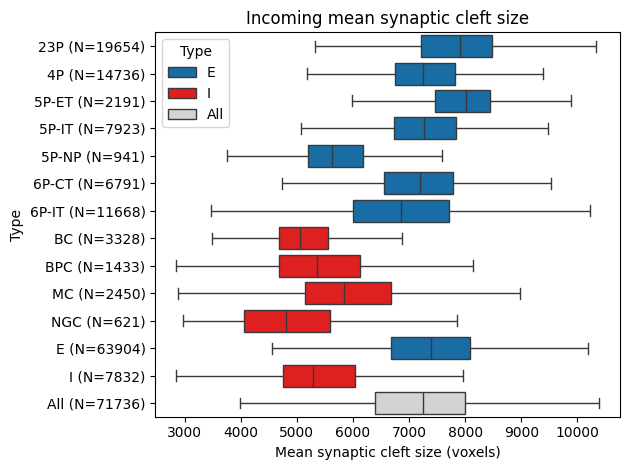

In [15]:
fig, ax = plt.subplots()
sns.boxplot(y="type_", x="ds_pre_syn_mean_weight", hue="clf_type", data=combined_df,
            palette={"I": inh_color, "E": ex_color, "All": "lightgray"}, showfliers=False)
plt.title("Incoming mean synaptic cleft size")
plt.xlabel("Mean synaptic cleft size (voxels)")
plt.ylabel("Type")
ax.set_yticks(range(len(comb_cell_type_counts_labels)))
ax.set_yticklabels(comb_cell_type_counts_labels)
plt.legend(title="Type");plt.tight_layout();plt.show()
fig.savefig('figures/in_weight.png')

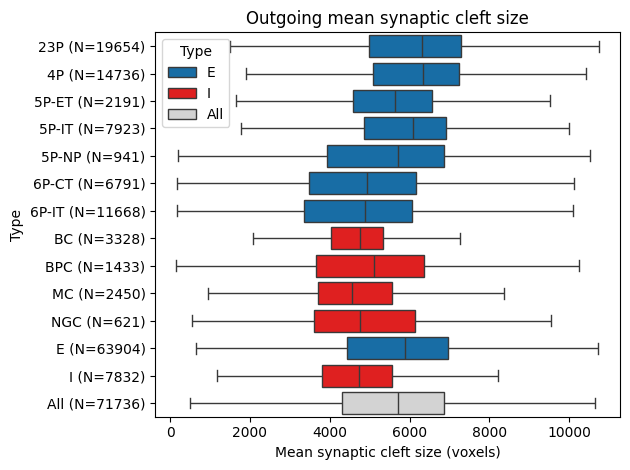

In [16]:
fig, ax = plt.subplots()
sns.boxplot(y="type_", x="ds_post_syn_mean_weight", hue="clf_type", data=combined_df,
            palette={"I": inh_color, "E": ex_color, "All": "lightgray"}, showfliers=False)
plt.title("Outgoing mean synaptic cleft size")
plt.xlabel("Mean synaptic cleft size (voxels)")
plt.ylabel("Type")
ax.set_yticks(range(len(comb_cell_type_counts_labels)))
ax.set_yticklabels(comb_cell_type_counts_labels)
plt.legend(title="Type");plt.tight_layout();plt.show()
fig.savefig('figures/out_weight.png')

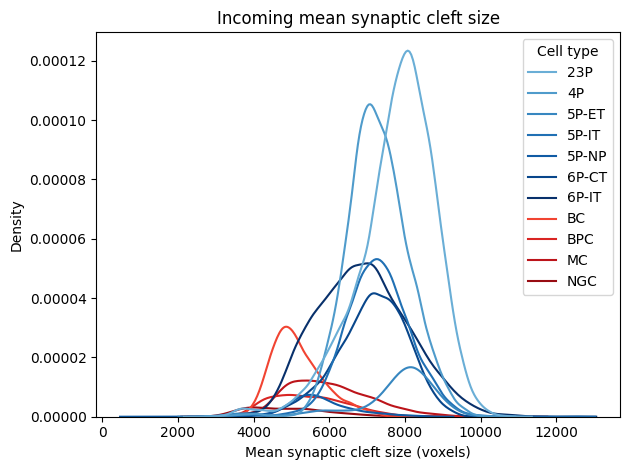

In [17]:
# supplementary materials 

fig, ax = plt.subplots()
sns.kdeplot(data=neurons_df_sorted, x="ds_pre_syn_mean_weight", hue="cell_type", ax=ax,
            palette=custom_palette, alpha=1)
# ax.set_xlim(0, 14000)
ax.set_title("Incoming mean synaptic cleft size")
ax.set_xlabel("Mean synaptic cleft size (voxels)");
sns.move_legend(ax, title='Cell type', loc='best')
plt.tight_layout();plt.show()

#### Weights In the EM volume

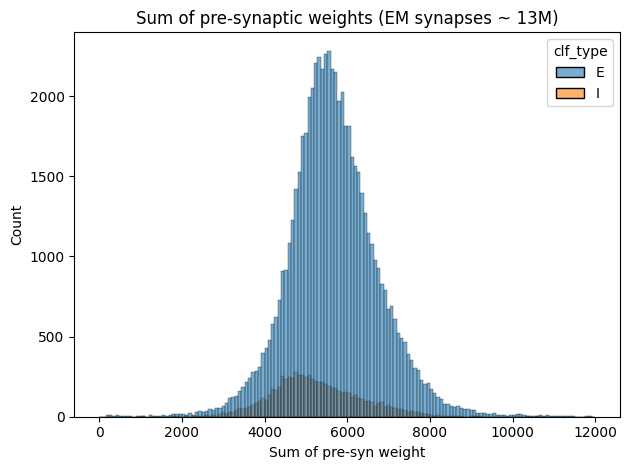

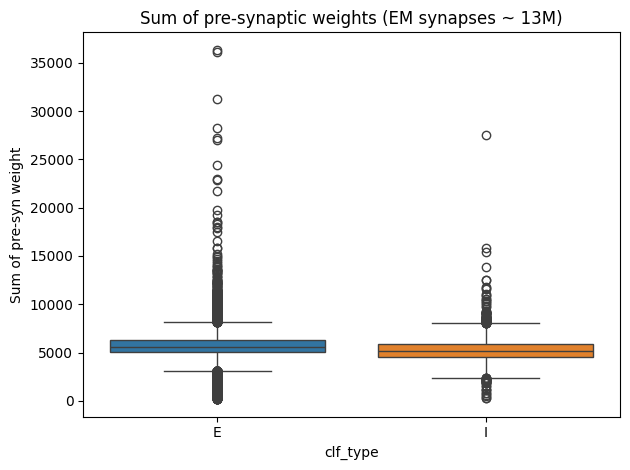

In [18]:
fig, ax = plt.subplots()
sns.histplot(data=neurons_df, x="pre_syn_weight", hue="clf_type",bins=150,
             alpha=0.6, ax=ax, binrange=(0, 12000))
ax.set_title("Sum of pre-synaptic weights (EM synapses ~ 13M)");
ax.set_xlabel("Sum of pre-syn weight");ax.set_ylabel("Count")
plt.tight_layout();plt.show()

fig, ax = plt.subplots()
sns.boxplot(x="clf_type", y="pre_syn_weight", hue="clf_type", data=neurons_df)
plt.title("Sum of pre-synaptic weights (EM synapses ~ 13M)")
plt.ylabel("Sum of pre-syn weight")
plt.tight_layout();plt.show()

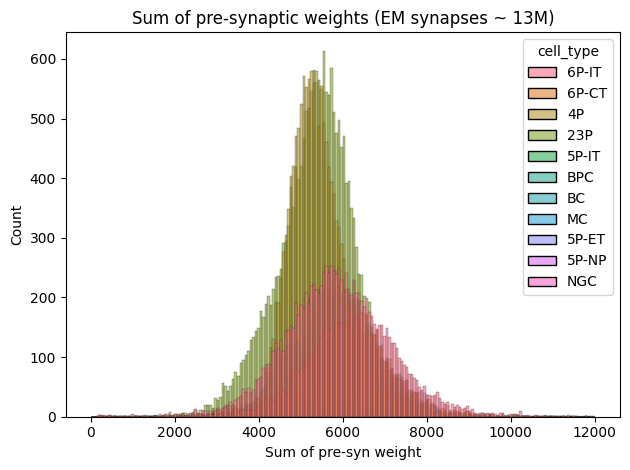

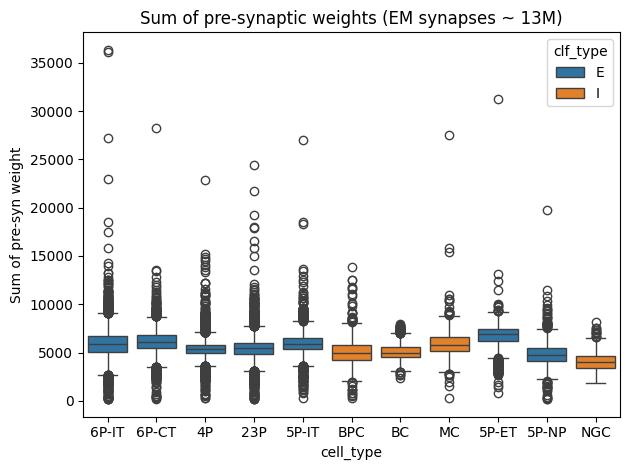

In [19]:
fig, ax = plt.subplots()
sns.histplot(data=neurons_df, x="pre_syn_weight", hue="cell_type",bins=200,
             alpha=0.6, ax=ax, binrange=(0, 12000))
ax.set_title("Sum of pre-synaptic weights (EM synapses ~ 13M)");
ax.set_xlabel("Sum of pre-syn weight");ax.set_ylabel("Count")
plt.tight_layout();plt.show()

fig, ax = plt.subplots()
sns.boxplot(x="cell_type", y="pre_syn_weight", hue="clf_type", data=neurons_df)
plt.title("Sum of pre-synaptic weights (EM synapses ~ 13M)")
plt.ylabel("Sum of pre-syn weight")
plt.tight_layout();plt.show()

### Sum of weights

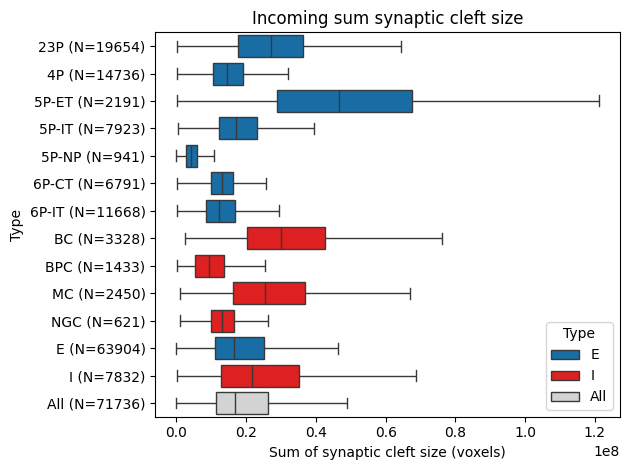

In [20]:
fig, ax = plt.subplots()
sns.boxplot(y="type_", x="ds_pre_syn_sum_weight", hue="clf_type", data=combined_df,
            palette={"I": inh_color, "E": ex_color, "All": "lightgray"}, showfliers=False)
plt.title("Incoming sum synaptic cleft size")
plt.xlabel("Sum of synaptic cleft size (voxels)")
plt.ylabel("Type")
ax.set_yticks(range(len(comb_cell_type_counts_labels)))
ax.set_yticklabels(comb_cell_type_counts_labels)
plt.legend(title="Type");plt.tight_layout();plt.show()
# fig.savefig('figures/in_weight_sum.png')

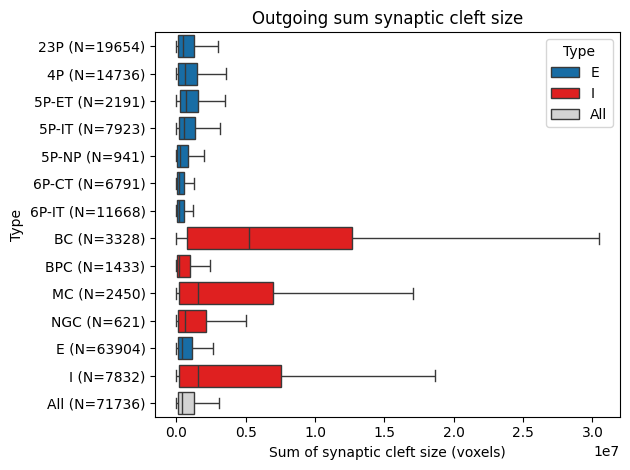

In [21]:
fig, ax = plt.subplots()
sns.boxplot(y="type_", x="ds_post_syn_sum_weight", hue="clf_type", data=combined_df,
            palette={"I": inh_color, "E": ex_color, "All": "lightgray"}, showfliers=False)
plt.title("Outgoing sum synaptic cleft size")
plt.xlabel("Sum of synaptic cleft size (voxels)")
plt.ylabel("Type")
ax.set_yticks(range(len(comb_cell_type_counts_labels)))
ax.set_yticklabels(comb_cell_type_counts_labels)
plt.legend(title="Type");plt.tight_layout();plt.show()
fig.savefig('figures/out_weight_sum.png')

#### Special featurs the EM has: we can look at "labeled" weights, i.e.: from excitatory, inhibitory, from BC...

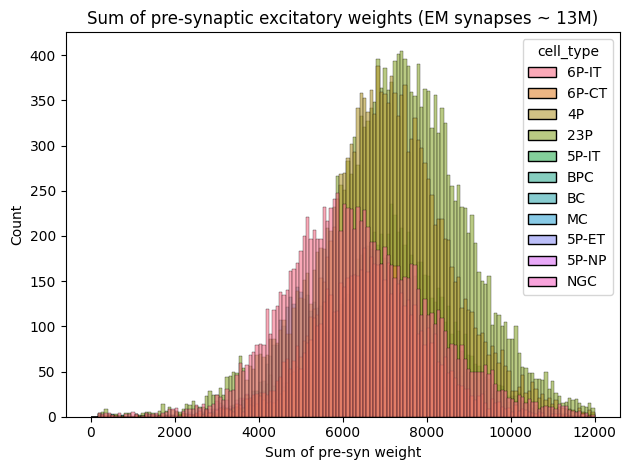

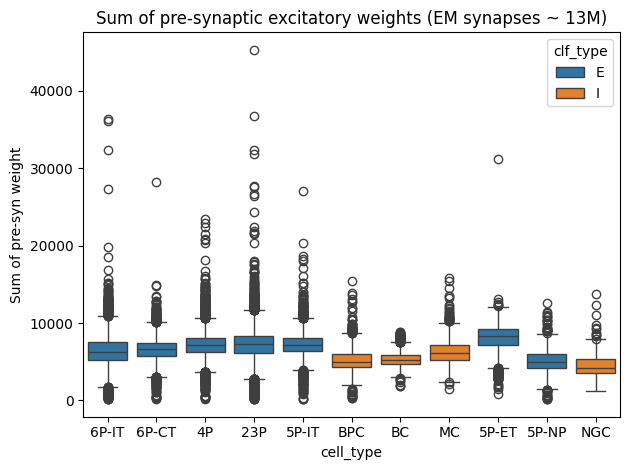

In [22]:
fig, ax = plt.subplots()
sns.histplot(data=neurons_df, x="ex_pre_syn_weight", hue="cell_type",bins=150,
             alpha=0.6, ax=ax, binrange=(0, 12000))
ax.set_title("Sum of pre-synaptic excitatory weights (EM synapses ~ 13M)");
ax.set_xlabel("Sum of pre-syn weight");ax.set_ylabel("Count")
plt.tight_layout();plt.show()

fig, ax = plt.subplots()
sns.boxplot(x="cell_type", y="ex_pre_syn_weight", hue="clf_type", data=neurons_df)
plt.title("Sum of pre-synaptic excitatory weights (EM synapses ~ 13M)")
plt.ylabel("Sum of pre-syn weight")
plt.tight_layout();plt.show()

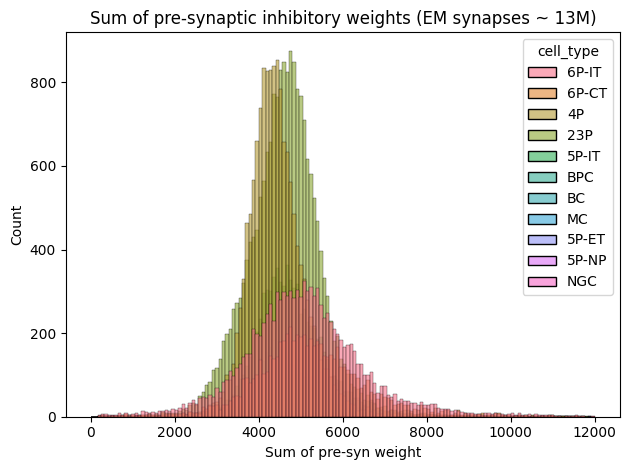

In [23]:
fig, ax = plt.subplots()
sns.histplot(data=neurons_df, x="inh_pre_syn_weight", hue="cell_type",bins=150,
             alpha=0.6, ax=ax, binrange=(0, 12000))
ax.set_title("Sum of pre-synaptic inhibitory weights (EM synapses ~ 13M)");
ax.set_xlabel("Sum of pre-syn weight");ax.set_ylabel("Count")
plt.tight_layout();plt.show()

### Volume

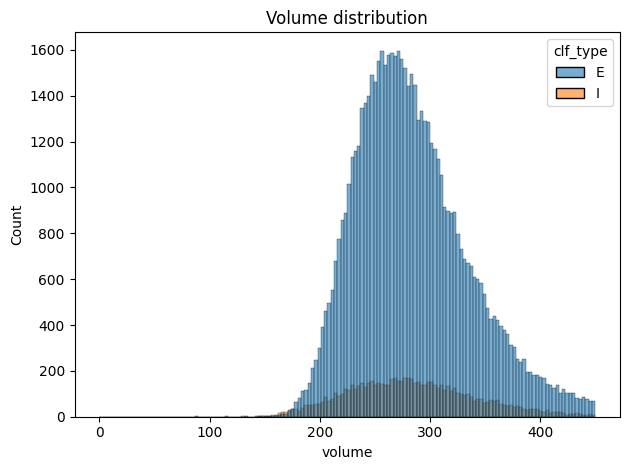

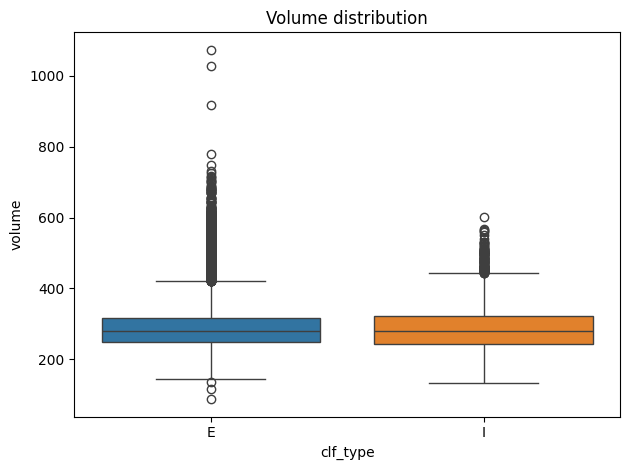

In [24]:
fig, ax = plt.subplots()
sns.histplot(data=neurons_df, x="volume", hue="clf_type",bins=150,binrange=(0, 450),
             alpha=0.6, ax=ax)
ax.set_title("Volume distribution");
ax.set_xlabel("volume");ax.set_ylabel("Count")
plt.tight_layout();plt.show()

fig, ax = plt.subplots()
sns.boxplot(x="clf_type", y="volume", hue="clf_type", data=neurons_df)
plt.title("Volume distribution")
plt.ylabel("volume")
plt.tight_layout();plt.show()

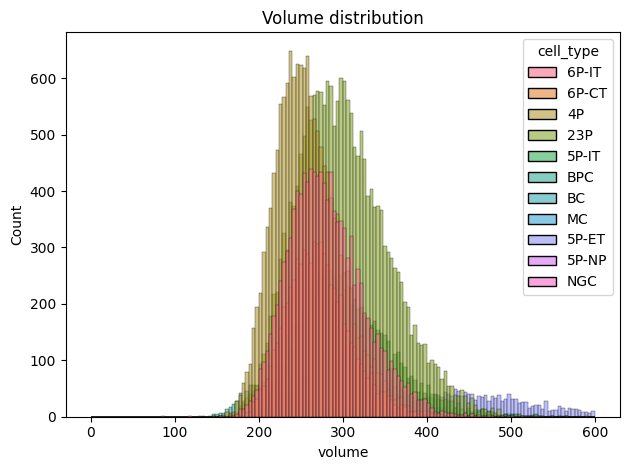

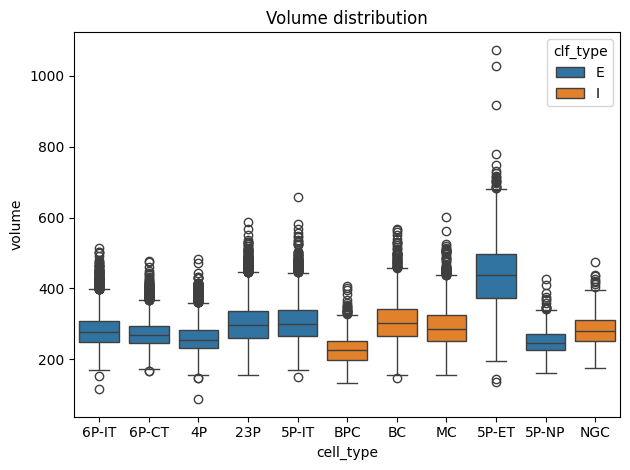

In [25]:
fig, ax = plt.subplots()
sns.histplot(data=neurons_df, x="volume", hue="cell_type",bins=150,binrange=(0, 600),
             alpha=0.6, ax=ax)
ax.set_title("Volume distribution");
ax.set_xlabel("volume");ax.set_ylabel("Count")
plt.tight_layout();plt.show()

fig, ax = plt.subplots()
sns.boxplot(x="cell_type", y="volume", hue="clf_type", data=neurons_df)
plt.title("Volume distribution")
plt.ylabel("volume")
plt.tight_layout();plt.show()

### Incoming in-degree Vs. Weights

63904
Correlation  0.3481307762685618


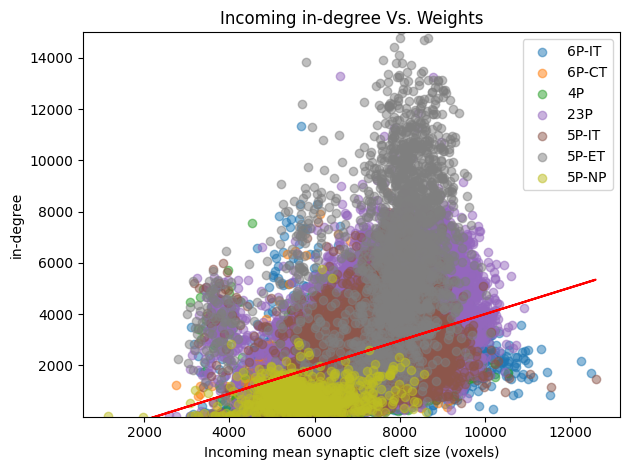

In [16]:
def weight_v_num_of_pre(df, color):
    x_col = 'ds_pre_syn_mean_weight'
    y_col = 'ds_num_of_pre_synapses'
    
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(subset=[x_col, y_col])
    print(len(df))
    correlation = df[x_col].corr(df[y_col])
    print(f"Correlation  {correlation}")
    
    X = df[x_col]
    y = df[y_col]
    
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    
    unique_types = df[color].unique()
    color_map = plt.colormaps['tab10']
    color_dict = {t: color_map(i/len(unique_types)) for i, t in enumerate(unique_types)}
    for t in unique_types:
        mask = df[color] == t
        plt.scatter(df.loc[mask, x_col], 
                    df.loc[mask, y_col], 
                    alpha=0.5, 
                    c=[color_dict[t]], 
                    label=t)
    
    plt.plot(df[x_col], model.predict(X), color='red')
    plt.ylim(0.0001, 15000) 
    # plt.xlim(-0.1, 10000) 
    
    plt.title("Incoming in-degree Vs. Weights");
    plt.xlabel("Incoming mean synaptic cleft size (voxels)");
    plt.ylabel("in-degree");
    plt.tight_layout();plt.legend(); plt.show()

weight_v_num_of_pre(neurons_df[neurons_df['clf_type'] == 'E'], color='cell_type')

7832
Correlation  -0.12000016865245071


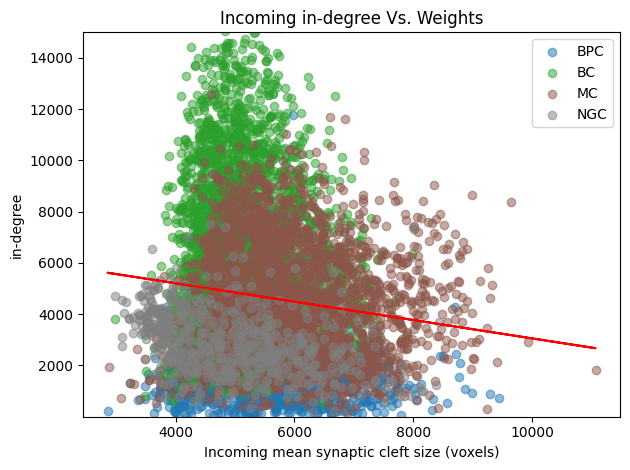

In [17]:
weight_v_num_of_pre(neurons_df[neurons_df['clf_type'] == 'I'], color='cell_type')